In [1]:
from astropy.table import Table
import matplotlib.pyplot as plt
import numpy as np

In [2]:
cat = Table.read('CUT_CLAUDS_HSC_VISTA_Ks23.3_PHYSPARAM_TM.fits')
cat_gal = cat[cat['CLASS'] == 0]
cat_gal = cat_gal[cat_gal['MASS_BEST']>7]

## Total Satellite Mass Evolution

In [3]:
total_mass_sat_log = open('total_mass_sat')
z = []
mass_sat= []
mass_sat_sf = []
mass_sat_q = []
std_mass_sat = []
std_mass_sat_sf = []
std_mass_sat_q = []

for line in total_mass_sat_log.readlines():
    z.append(eval(line.split()[0]))
    mass_sat.append(eval(line.split()[1]))
    mass_sat_sf.append(eval(line.split()[2]))
    mass_sat_q.append(eval(line.split()[3]))
    std_mass_sat.append(eval(line.split()[4]))
    std_mass_sat_sf.append(eval(line.split()[5]))
    std_mass_sat_q.append(eval(line.split()[6]))

z = np.array(z)
mass_sat = np.array(mass_sat)
mass_sat_sf = np.array(mass_sat_sf)
mass_sat_q = np.array(mass_sat_q)
std_mass_sat = np.array(std_mass_sat)
std_mass_sat_sf = np.array(std_mass_sat_sf)
std_mass_sat_q = np.array(std_mass_sat_q)

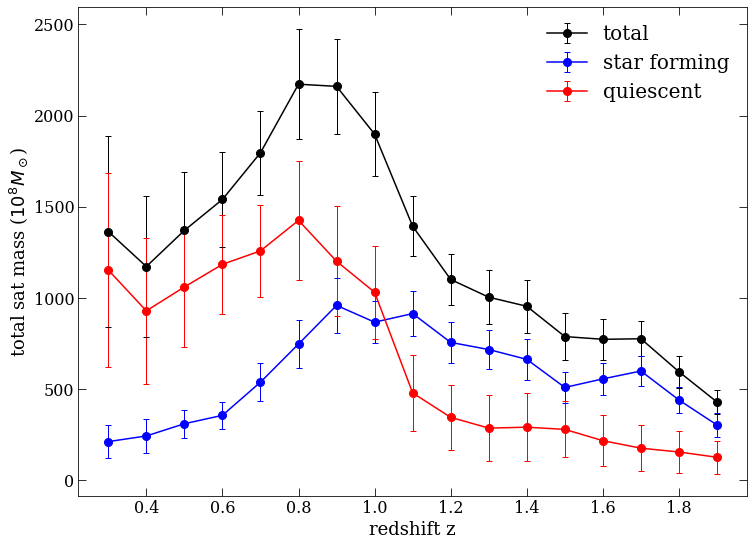

In [4]:
fig = plt.figure(figsize=(12,9))
plt.rc('font', family='serif'), plt.rc('xtick', labelsize=16), plt.rc('ytick', labelsize=16)

plt.errorbar(z,mass_sat, yerr=std_mass_sat, fmt='.-k',markersize=16, capsize=3, elinewidth=1,label='total')
plt.errorbar(z,mass_sat_sf, yerr=std_mass_sat_sf, fmt='.-b',markersize=16, capsize=3, elinewidth=1,label='star forming')
plt.errorbar(z,mass_sat_q, yerr=std_mass_sat_q, fmt='.-r',markersize=16, capsize=3, elinewidth=1, label='quiescent')

plt.xlabel('redshift z', fontsize=18)
plt.ylabel(r'total sat mass ($10^8 M_\odot$)', fontsize=18)
plt.tick_params(axis='both',direction='in',which='major',length=8,top='on',right='on')
plt.tick_params(axis='both',direction='in',which='minor',length=4,top='on',right='on')
plt.legend(fontsize=20,frameon=False)
plt.savefig('total_sat_mass_z.png')
plt.show()

In [5]:
cat_high_z = cat_gal[cat_gal['ZPHOT']>5]
np.min(abs(cat_high_z['MASS_BEST']))

8.03579

## Uniformity of Blank Pointings

In [6]:
from astropy.coordinates import SkyCoord, match_coordinates_sky
from random import random
import astropy.units as u
from astropy.cosmology import Planck15, WMAP9

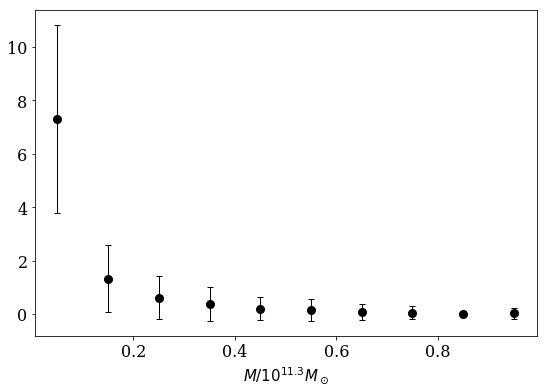

In [7]:
z = 1.1
dis = WMAP9.angular_diameter_distance(z).value

cat_massive_gal = cat_gal[cat_gal['MASS_BEST'] > 11.3]
cat_massive_z_slice = cat_massive_gal[abs(cat_massive_gal['ZPHOT']-z)<0.1]
cat_all_z_slice = cat_gal[abs(cat_gal['ZPHOT'] - z) < 0.1]

cat_massive_z_slice['RA'].unit = u.deg
cat_massive_z_slice['DEC'].unit = u.deg
coord_massive_gal = SkyCoord.guess_from_table(cat_massive_z_slice)

counts_var = []
for i in range(0,1000):
    rand_id = int(random()*len(cat_all_z_slice))
    ra_rand = cat_all_z_slice[rand_id]['RA']
    dec_rand = cat_all_z_slice[rand_id]['DEC']
    idx, sep2d, dist3d = match_coordinates_sky(SkyCoord(ra_rand, dec_rand, unit="deg"), coord_massive_gal, nthneighbor=1)
    
    if sep2d.degree > 1.5/dis/np.pi*180:
        cat_neighbors_rand = cat_all_z_slice[(cat_all_z_slice['RA'] - ra_rand) ** 2 + (cat_all_z_slice['DEC'] - dec_rand) ** 2 < (0.5 / dis / np.pi * 180) ** 2]
        mass_neighbors_rand = cat_neighbors_rand['MASS_BEST']
        count_gal_rand, edges_rand = np.histogram(10**(mass_neighbors_rand - 11.3) , np.arange(0,1.01,0.1))
        
        counts_var.append(count_gal_rand)

counts_var_all = np.vstack(counts_var)
std = np.std(counts_var_all, axis=0)
mean = np.mean(counts_var_all, axis=0)

fig = plt.figure(figsize=(9,6))
plt.errorbar(edges_rand[0:-1]+0.05,mean,yerr=std, fmt='.k', markersize=16, capsize=3, elinewidth=1)
# plt.ylim([0,15])
plt.xlabel(r'$M/10^{11.3}M_\odot$', fontsize=15)
plt.savefig('background.png')
plt.show()

In [8]:
from astropy.stats import bootstrap

(1757.816282205569, 1056.2553505463031)
(1753.6726929963206, 217.38876811948865)


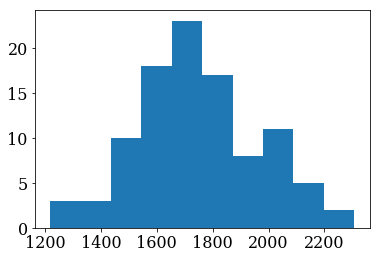

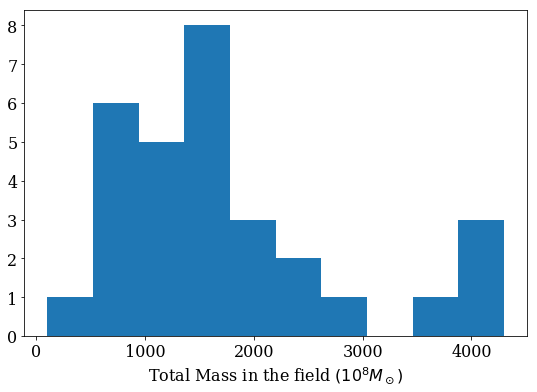

In [9]:
z = 1.1
dis = Planck15.angular_diameter_distance(z).value

cat_massive_gal = cat_gal[cat_gal['MASS_BEST'] > 11.3]
cat_massive_z_slice = cat_massive_gal[abs(cat_massive_gal['ZPHOT']-z)<0.1]
cat_all_z_slice = cat_gal[abs(cat_gal['ZPHOT'] - z) < 0.1]

cat_massive_z_slice['RA'].unit = u.deg
cat_massive_z_slice['DEC'].unit = u.deg
coord_massive_gal = SkyCoord.guess_from_table(cat_massive_z_slice)

total_mass_neighbrs_rand = []
for i in range(0,200):
    rand_id = int(random()*len(cat_all_z_slice))
    ra_rand = cat_all_z_slice[rand_id]['RA']
    dec_rand = cat_all_z_slice[rand_id]['DEC']
    idx, sep2d, dist3d = match_coordinates_sky(SkyCoord(ra_rand, dec_rand, unit="deg"), coord_massive_gal, nthneighbor=1)
    
    if sep2d.degree > 3.0/dis/np.pi*180:
        cat_neighbors_rand = cat_all_z_slice[(cat_all_z_slice['RA'] - ra_rand) ** 2 + (cat_all_z_slice['DEC'] - dec_rand) ** 2 < (0.5 / dis / np.pi * 180) ** 2]
        if np.sum(10**(cat_neighbors_rand[cat_neighbors_rand['MASS_BEST']>10]['MASS_BEST']-8))==0: continue
        total_mass_neighbrs_rand.append(np.sum(10**(cat_neighbors_rand[cat_neighbors_rand['MASS_BEST']>10]['MASS_BEST']-8)))

total_mass_neighbrs_rand = np.array(total_mass_neighbrs_rand)
print(np.mean(total_mass_neighbrs_rand), np.std(total_mass_neighbrs_rand))
bootresult = bootstrap(total_mass_neighbrs_rand,100,bootfunc=np.mean)
plt.hist(bootresult)
print(np.mean(bootresult), np.std(bootresult))

fig = plt.figure(figsize=(9,6))
plt.hist(total_mass_neighbrs_rand)
plt.xlabel(r'Total Mass in the field $(10^8 M_\odot)$',fontsize=16)
plt.savefig('background_mass.png')
plt.show()

## massive gal distribution (completeness plot)

In [10]:
# mass completeness limit at different redshift bins

m_min_list = []
for z in np.arange(1,30)/10.:
    cat_all_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
    cat_all_z_slice.sort('Ks')
    cat_all_z_slice = cat_all_z_slice[0:int(0.2*len(cat_all_z_slice))]
    
    m_min_gals = cat_all_z_slice['MASS_BEST']+0.4*(cat_all_z_slice['Ks']-23.3)
    m_min_gals.sort()
    m_min_z = m_min_gals[int(0.95*len(m_min_gals))]
    
    m_min_list.append(m_min_z)

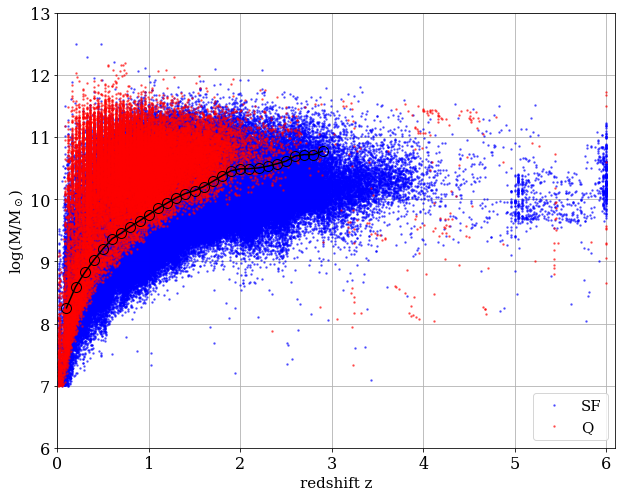

In [11]:
fig = plt.figure(figsize=(10,8))
plt.plot(cat_gal[cat_gal['SSFR_BEST']>-11]['ZPHOT'],cat_gal[cat_gal['SSFR_BEST']>-11]['MASS_BEST'],'.b',markersize=3,alpha=0.5,label='SF')
plt.plot(cat_gal[cat_gal['SSFR_BEST']<-11]['ZPHOT'],cat_gal[cat_gal['SSFR_BEST']<-11]['MASS_BEST'],'.r',markersize=3,alpha=0.5,label='Q')
plt.plot(np.arange(1,30)/10., m_min_list,'-ok',markersize=10,markerfacecolor="None")
plt.ylim([6,13])
plt.xlim([0,6.1])
plt.xlabel('redshift z', fontsize=15)
plt.ylabel(r'log(M/M$_\odot$)', fontsize=15)
plt.grid(True)
plt.legend(fontsize=15,loc='lower right')
plt.savefig('completeness.png')
plt.show()

## angular separation

In [12]:
from astropy.coordinates import SkyCoord
from astropy import units as u

In [13]:
def spherical_separation(ra1, dec1, ra2, dec2):
    '''ra1,dec1 can be array or scalar. ra2,dec2 are scalars'''
    ra1 = ra1/180.*np.pi
    ra2 = ra2/180.*np.pi
    dec1 = dec1/180.*np.pi
    dec2 = dec2/180.*np.pi
    return np.arccos(np.sin(dec1)*np.sin(dec2)+np.cos(dec1)*np.cos(dec2)*np.cos(ra1-ra2))/np.pi*180

def separation(ra1, dec1, ra2, dec2):
    '''ra1,dec1 can be array or scalar. ra2,dec2 are scalars'''
    return np.sqrt((ra1-ra2)**2+(dec1-dec2)**2)

In [14]:
ra1 = cat_gal['RA']
dec1 = cat_gal['DEC']
ra2 = cat_gal[122]['RA']
dec2 = cat_gal[122]['DEC']
# print(ra1, dec1, ra2, dec2)
# print(spherical_separation(ra1, dec1, ra2, dec2))
# print(separation(ra1, dec1, ra2, dec2))

c1 = SkyCoord(ra1*u.deg,dec1*u.deg)
c2 = SkyCoord(ra2*u.deg,dec2*u.deg)

## physical search radius

In [15]:
from astropy.cosmology import Planck15, WMAP9

In [16]:
z=0.3
dis = WMAP9.angular_diameter_distance(z).value
print(dis)
0.5/dis/np.pi*180

930.498307159


0.030787686056097347

## Volumne Density Matching
for massive central gals

In [17]:
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.stats import bootstrap

m_median = np.array([])
m_16 = np.array([])
m_84 = np.array([])
m_low = np.array([])
m_total = np.array([])
m_mean = np.array([])
m_mean_error = np.array([])
gal_sf = []  # SF galaxy number density
gal_q = []  # Q galaxy number density

for z in np.arange(0.3, 2.0, 0.1):
    dis_l = WMAP9.comoving_distance(z-0.1).value
    dis_h = WMAP9.comoving_distance(z+0.1).value
    
    total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
    survey_v = total_v * 4 / 41253.05  #Mpc^3
    density = 0.00003 # Mpc^-3
    num = int(density*survey_v)  # surface densisty propto dis**2
    
    cat_gal_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
    cat_gal_z_slice.sort('MASS_BEST')
    cat_gal_z_slice.reverse()
    cat_massive_gal_z = cat_gal_z_slice[:num]
    gal_sf.append(len(cat_massive_gal_z[cat_massive_gal_z['SSFR_BEST']>-11])/survey_v)  # number density of sf gals in this bin
    gal_q.append(len(cat_massive_gal_z[cat_massive_gal_z['SSFR_BEST']<-11])/survey_v)  # number density of q gals in this bin
    
    for gal in cat_massive_gal_z:
        coord_gal_z_slice = SkyCoord(cat_gal_z_slice['RA'] * u.deg, cat_gal_z_slice['DEC'] * u.deg)
        coord_gal = SkyCoord(gal['RA'] * u.deg, gal['DEC'] * u.deg)
        cat_neighbors = cat_gal_z_slice[coord_gal_z_slice.separation(coord_gal).degree < 0.5/dis/np.pi*180]
        cat_neighbors = cat_neighbors[cat_neighbors['ID'] != gal['ID']]  # exclude central gal itself
        
        if len(cat_neighbors) == 0:  # exlucde central gals which has no companion
            cat_massive_gal_z = cat_massive_gal_z[cat_massive_gal_z['ID'] != gal['ID']]
            continue
        if gal['MASS_BEST'] < max(cat_neighbors['MASS_BEST']):  # exclude central gals which has larger mass companion
            cat_massive_gal_z = cat_massive_gal_z[cat_massive_gal_z['ID'] != gal['ID']]
    
    print(z, cat_gal_z_slice[num]['MASS_BEST'], num)
    m_median = np.append(m_median,10**(np.median(cat_massive_gal_z['MASS_BEST'])-10))
    m_16 = np.append(m_16,10**(np.percentile(cat_massive_gal_z['MASS_BEST'],16)-10))
    m_84 = np.append(m_84,10**(np.percentile(cat_massive_gal_z['MASS_BEST'],84)-10))
    m_low = np.append(m_low, 10**(cat_massive_gal_z['MASS_BEST'][-1]-10))
    m_total = np.append(m_total, sum( 10**(cat_massive_gal_z['MASS_BEST'] - 10) ))
    m_mean = np.append(m_mean, m_total[-1]/len(cat_massive_gal_z))
    
    bootsresult_m_mean = bootstrap(10**(cat_massive_gal_z['MASS_BEST']-10), 20, bootfunc=np.mean)
    m_mean_error = np.append(m_mean_error, np.std(bootsresult_m_mean))
print(m_mean)
print(m_mean_error)

(0.3, 11.4541, 40)


/home/lejay/.local/lib/python2.7/site-packages/numpy/core/fromnumeric.py:664: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedColumn.
  a.partition(kth, axis=axis, kind=kind, order=order)


(0.4, 11.4595, 64)
(0.5, 11.4779, 89)
(0.6000000000000001, 11.4472, 115)
(0.7000000000000002, 11.4007, 140)
(0.8000000000000003, 11.3679, 164)
(0.9000000000000001, 11.3685, 186)
(1.0000000000000002, 11.3607, 205)
(1.1000000000000003, 11.3116, 223)
(1.2000000000000004, 11.3039, 239)
(1.3000000000000005, 11.2925, 252)
(1.4000000000000004, 11.2817, 264)
(1.5000000000000004, 11.2467, 274)
(1.6000000000000005, 11.2058, 283)
(1.7000000000000004, 11.1989, 290)
(1.8000000000000005, 11.1964, 296)
(1.9000000000000006, 11.1869, 300)
[52.98099554 48.15189567 49.40084509 45.57015896 43.95657631 37.23324021
 34.83371186 34.25672256 30.74339522 29.06467219 27.66113977 26.3676098
 26.5165525  24.80466929 23.64932953 23.32040622 23.30601992]
[8.73288486 6.5087362  2.58156303 2.51837312 2.40047879 2.54038631
 1.20003939 0.98377815 0.98011098 0.75419257 0.61098101 0.5824914
 0.81770383 0.65694756 0.54668156 0.54308063 0.55228083]


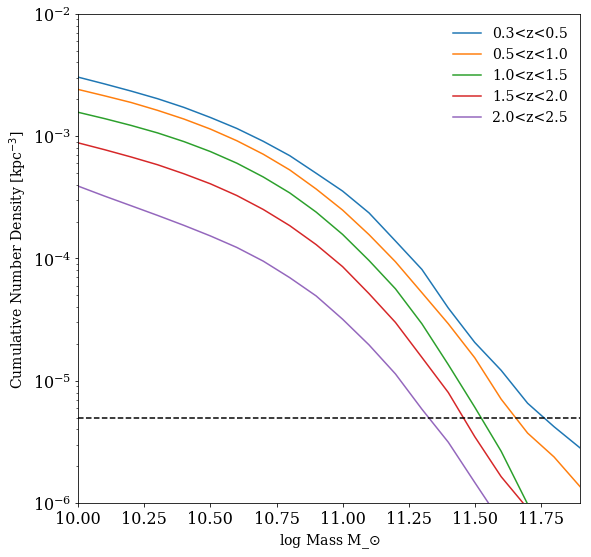

In [18]:
z=0.4
fig = plt.figure(figsize=(9,9))
dis_l = WMAP9.comoving_distance(z-0.1).value
dis_h = WMAP9.comoving_distance(z+0.1).value
    
total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
survey_v = total_v * 4 / 41253.05  #Mpc^3
cat_gal_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
cat_gal_z_slice.sort('MASS_BEST')
cat_gal_z_slice.reverse()
    
density_list = []
for mass in np.arange(10,12,0.1):
    density = len(cat_gal_z_slice[cat_gal_z_slice['MASS_BEST']>mass])/survey_v
    density_list.append(density)
plt.plot(np.arange(10,12,0.1),density_list,label=str(round(z-0.1,1))+'<z<'+str(round(z+0.1,1)))

for z in np.arange(0.75, 2.5, 0.5):
    dis_l = WMAP9.comoving_distance(z-0.25).value
    dis_h = WMAP9.comoving_distance(z+0.25).value
    
    total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
    survey_v = total_v * 4 / 41253.05  #Mpc^3
    cat_gal_z_slice = cat_gal[abs(cat_gal['ZPHOT']-z)<0.25]
    cat_gal_z_slice.sort('MASS_BEST')
    cat_gal_z_slice.reverse()
    
    density_list = []
    for mass in np.arange(10,12,0.1):
        density = len(cat_gal_z_slice[cat_gal_z_slice['MASS_BEST']>mass])/survey_v
        density_list.append(density)
    
    plt.plot(np.arange(10,12,0.1),density_list,label=str(round(z-0.25,1))+'<z<'+str(round(z+0.25,1)))

plt.axhline(y=5e-6,linestyle='--',color='k')
plt.yscale('log')
plt.ylim([1e-6,1e-2])
plt.xlim([10,11.9])
plt.xlabel(r'log Mass M_$\odot$',fontsize=14)
plt.ylabel(r'Cumulative Number Density [kpc$^{-3}$]',fontsize=14)

plt.legend(fontsize=14,frameon=False)
plt.savefig('cumulative_density.png')
plt.show()
plt.close()

## Number density evolution SF&Q

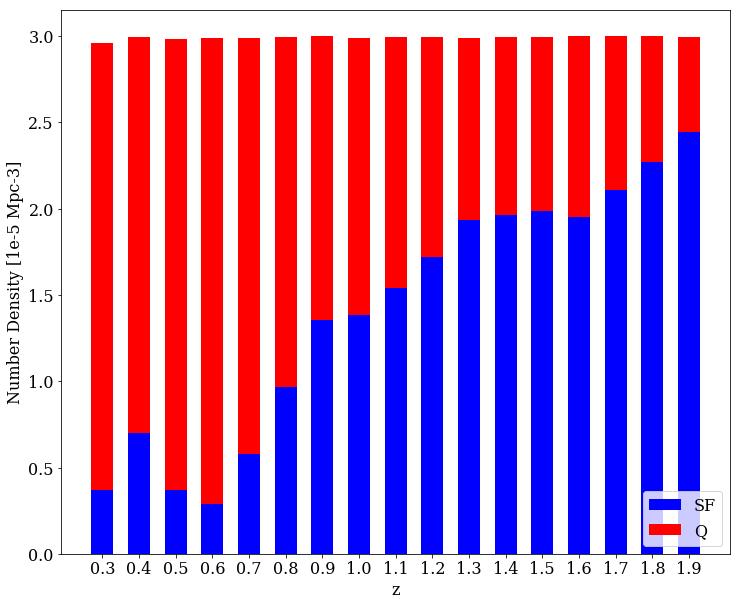

In [19]:
np.set_printoptions(precision=1)
z_list = np.arange(3,20)/10.
ind = z_list   # the x locations for the groups
width = 0.06      # the width of the bars: can also be len(x) sequence

fig = plt.figure(figsize=(12,10))
p1 = plt.bar(ind, np.array(gal_sf)*1e5, width,color='b')
p2 = plt.bar(ind, np.array(gal_q)*1e5, width,bottom=np.array(gal_sf)*1e5,color='r')

plt.ylabel('Number Density [1e-5 Mpc-3]',fontsize=16)
plt.xlabel('z',fontsize=16)
plt.xticks(ind, np.arange(3,20)/10.)
# plt.yticks(np.arange(0, 81, 10))
plt.legend((p1[0], p2[0]), ('SF', 'Q'),fontsize=16,loc='lower right')
plt.savefig('number_density_sfq.png')
plt.show()

## cumulative massive gals number counts

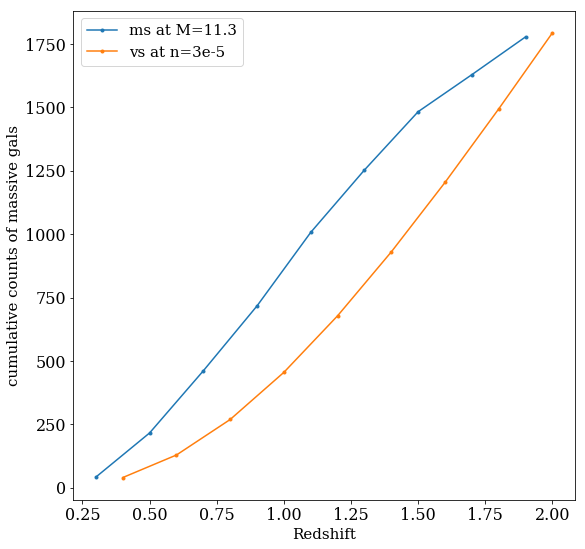

In [20]:
fig = plt.figure(figsize=(9,9))

massive_gal_counts = []
massive_gal_counts_vs = []
for z in np.arange(0.3, 2.0, 0.2):
    
    # constant mass selection
    cat_gal_z_slice = cat_gal[cat_gal['ZPHOT']>0.2]
    cat_gal_z_slice = cat_gal_z_slice[cat_gal_z_slice['ZPHOT']<z]
    cat_gal_massive_z = cat_gal_z_slice[cat_gal_z_slice['MASS_BEST']>11.3]
    massive_gal_counts.append(len(cat_gal_massive_z))
    
    # constant volume density selection
    dis_l = WMAP9.comoving_distance(z-0.1).value
    dis_h = WMAP9.comoving_distance(z+0.1).value
    total_v = 4./3*np.pi*(dis_h**3 - dis_l**3) # Mpc^3
    survey_v = total_v * 4 / 41253.05  #Mpc^3
    density = 0.00003 # Mpc^-3
    num = int(density*survey_v)  # surface densisty propto dis**2
    
    cat_gal_z_slice_vs = cat_gal[abs(cat_gal['ZPHOT']-z)<0.1]
    cat_gal_z_slice_vs.sort('MASS_BEST')
    cat_gal_z_slice_vs.reverse()
    cat_massive_gal_z_vs = cat_gal_z_slice_vs[:num]
    if z>0.31:
        massive_gal_counts_vs.append(massive_gal_counts_vs[-1]+len(cat_massive_gal_z_vs)) # vs = volume selected
    else:
        massive_gal_counts_vs.append(len(cat_massive_gal_z_vs))
    
plt.plot(np.arange(0.3, 2.0, 0.2),massive_gal_counts,'.-',label='ms at M=11.3')
plt.plot(np.arange(0.3, 2.0, 0.2)+0.1,massive_gal_counts_vs,'.-',label='vs at n=3e-5')
plt.xlabel('Redshift',fontsize=15)
plt.ylabel('cumulative counts of massive gals', fontsize=15)
plt.legend(fontsize=15)
plt.show()

## Pair Fraction
galaxies with at least one companinon more massive than its 1/10 mass

In [21]:
fig = plt.figure(figsize=(10,8))
plt.show()

### Mass Growth Plot

In [22]:
mass_growth_mean_k = open('mass_growth_k').readlines()
mass_growth_mean_j = open('mass_growth_j').readlines()

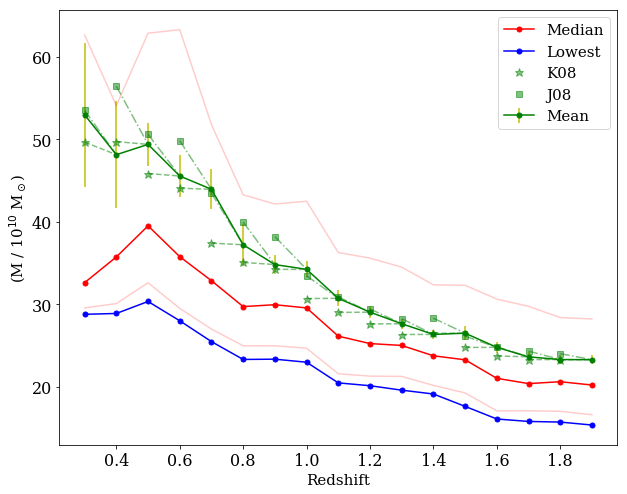

In [23]:
z_list = np.arange(0.3, 2.0, 0.1)

fig = plt.figure(figsize=(10,8))
plt.plot(z_list,m_median,'.-r',markersize=10,label='Median')
plt.plot(z_list,m_16,'-r',alpha=0.2)
plt.plot(z_list,m_84,'-r',alpha=0.2)
plt.plot(z_list,m_low,'.-b',markersize=10,label='Lowest')
plt.errorbar(z_list,m_mean,yerr=m_mean_error,fmt='.-g', markersize=10,ecolor='y', label='Mean')

for i in range(1,len(z_list)):
    mass_growth = eval(mass_growth_mean_k[i])
    original_mass = m_mean[i]
    merged_mass = original_mass + mass_growth
    plt.plot([z_list[i-1],z_list[i]],[merged_mass,original_mass],'--g',alpha=0.5)
    plt.plot(z_list[i-1],merged_mass,'*g',markersize=9,alpha=0.5,label='K08' if 'K08' \
            not in plt.gca().get_legend_handles_labels()[1] else '')
    
    mass_growth = eval(mass_growth_mean_j[i])
    original_mass = m_mean[i]
    merged_mass = original_mass + mass_growth
    plt.plot([z_list[i-1],z_list[i]],[merged_mass,original_mass],'-.g',alpha=0.5)
    plt.plot(z_list[i-1],merged_mass,'sg',markersize=6,alpha=0.5,label='J08' if 'J08' \
            not in plt.gca().get_legend_handles_labels()[1] else '')

plt.xlabel('Redshift',fontsize=15)
plt.ylabel(r'(M / 10$^{10}$ M$_\odot$)',fontsize=15)
plt.legend(fontsize=15)
plt.savefig('mass=_growth.png')
plt.show()

## Test Plot

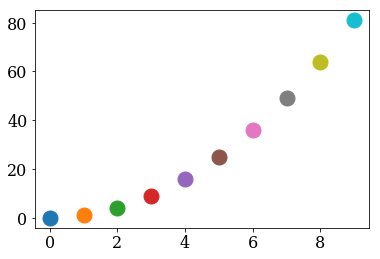

In [24]:
for i in range(10):
    plt.plot(i,i**2,'o',markersize=15)
    
plt.show()

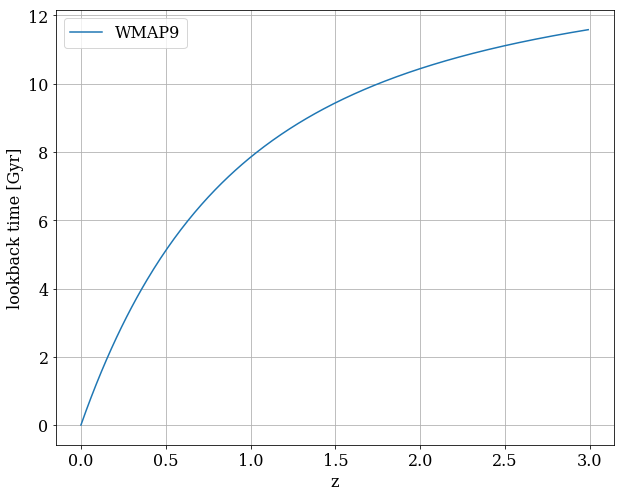

In [25]:
t = []
for z in np.arange(0,3,0.01):
    t.append(WMAP9.lookback_time(z).value)

fig = plt.figure(figsize=(10,8))    
plt.plot(np.arange(0,3,0.01),t, label='WMAP9')
plt.xlabel('z',fontsize=16)
plt.ylabel('lookback time [Gyr]',fontsize=16)
plt.legend(fontsize=16)
plt.grid()
plt.show()